# Semi_defect_finder — Ensemble (Soft Voting)

> **Dataset**: https://www.kaggle.com/datasets/arbazkhan971/anomaly-detection/data
>
> **GitHub**: https://github.com/yrtny70127/Semiconductor_Quality_Prospect.git

## 도메인
**반도체 제조 공정** — 제조 공정에서 결함 징후 감지

## 비즈니스 맥락

반도체 제조 공정은 매우 정밀하며, 수천 개의 센서가 10밀리초(ms) 단위로 방대한 데이터를 수집합니다. 
제조사는 결함이 있는 제품을 생산하는 것을 막아야 하므로, 이 데이터를 통해 불량을 조기에 탐지하는 것이 필수적입니다.

희소성 : 실제 공정에서 불량품은 정상품에 비해 매우 드물게 발생하므로, 데이터가 극도로 **불균형(Imbalanced)**합니다.

익명화 및 고차원: 보안상의 이유로 1,558개의 피처 이름이 모두 익명화되어 있으며, 어떤 센서의 값인지 알 수 없는 고차원 데이터입니다.

## 목표

- 이상 탐지 : 머신러닝 또는 딥러닝 모델을 구축하여 수천 개의 센서 데이터 패턴을 분석하고, 정상 제품과 결함 제품을 정확히 분류하는 것입니다.

- 일반화 : 학습된 모델이 본 적 없는 새로운 데이터(Test set)에 대해서도 높은 성능을 발휘하도록 만드는 것이 핵심 과제입니다.

- 평가 지표: 불균형한 데이터셋임을 고려하여, 단순 정확도가 아닌 점수를 최대화하는 것을 목표로 합니다.

## 데이터셋

| 항목 | 내용 |
|------|------|
| **파일** | `train.csv` (1,763 × 1,559) |
| **샘플** | 1,763개 (각각 하나의 생산 요소) |
| **피처** | 1,559개 센서 측정값 |
| **타겟** | Class (`0` = Pass, `1` = Fail) |
| **불균형** | Fail 비율 ~8.1% (1:12.3) |

## 전략

**1. 환경 설정** — 라이브러리 import, 경로 설정

**2. 데이터 로드** — `train.csv` 읽기

**3. 전처리**
- 0 컬럼 제거 → |상관계수| ≥ 0.8 제거

**4. EDA**
- 타겟 분포 확인, PCA / t-SNE 시각화, Target Correlation Top 20 + 박스플롯 · 히스토그램

**5. 분할 & 피처 선택**
- Train 70% / Valid 15% / Test 15% (Stratified)
- ANOVA F-test Top 20 (Train-only fit → Valid/Test 동일 적용)

**6. 모델링**
- 개별 모델 베이스라인 (Baseline, threshold=0.5) → 5개 모델 기본 성능 확인
- 3종 샘플링 (Baseline / Under / SMOTE) × 5개 모델 = **15개 조합** Recall · Specificity · BalAcc 비교

**7. 앙상블**
- Top 3 모델 선택: 역할 분담 + 반대쪽 하한 필터(≥ 0.3)
- Soft Voting: 26가지 가중치 × 91 threshold → Valid BalAcc 최적화

**8. 검증**
- Multi-Seed (10 seeds) 전체 파이프라인 독립 반복
- Valid-Test gap + 모델 선택 빈도로 안정성 확인7

## 1. 환경 설정

In [1]:
# =========================================
# 1) Imports (preprocess & modeling)
# =========================================
import os
import warnings
from pathlib import Path
from collections import OrderedDict, Counter

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.base import clone

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, recall_score

In [2]:
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)

## 2. 데이터 로드

In [3]:
# =========================================
# 2) Load data & basic checks
# =========================================

train_df = pd.read_csv('C:/Users/0726b/OneDrive - 부경대학교/바탕 화면/projec_semiconductor/NEW/Train.csv')
test_df = pd.read_csv('C:/Users/0726b/OneDrive - 부경대학교/바탕 화면/projec_semiconductor/NEW/Test.csv')

test_df.head()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,60.0000,468.0000,7.8000,1.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108.0000,179.0000,1.6574,1.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0000,1.0000,2.0000,0.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60.0000,468.0000,7.8000,1.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60.0000,120.0000,2.0000,1.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


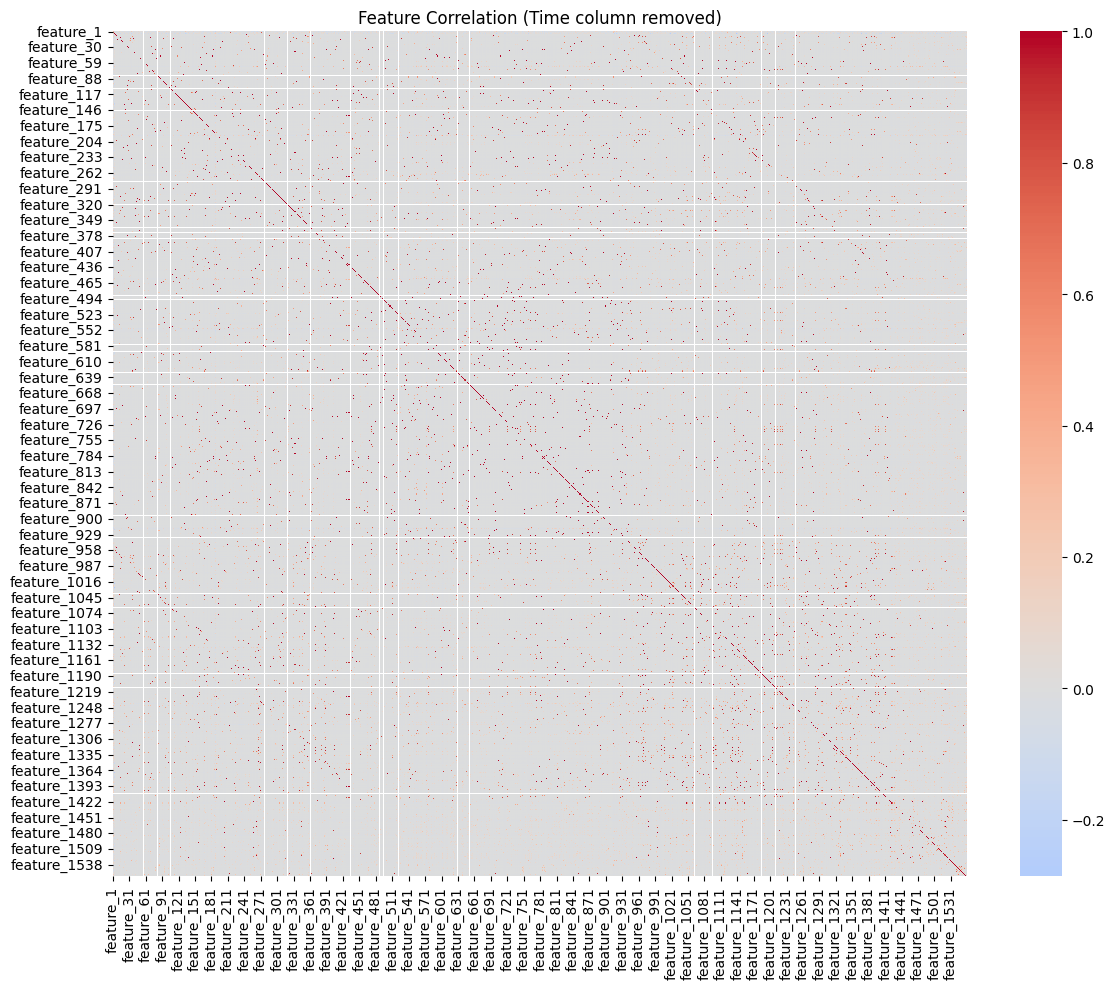

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# =========================================
# 2. 데이터 로드 & 기본 확인
# =========================================


# Numeric-only correlation
corr = train_df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (Time column removed)")
plt.tight_layout()
plt.show()

train_df.head()


## 3. 전처리 (Feature Engineering)
> 불필요한 피처 제거

### 3-1. 분산 0 컬럼 제거 + 상관행렬 히트맵

In [5]:
# 모든 값이 0인 컬럼 식별
zero_cols = [col for col in train_df.columns if (train_df[col] == 0).all()]

# 결과 출력
print(f"값이 전부 0인 컬럼 목록: {zero_cols}")

# train_df에서 해당 컬럼 삭제
train_df = train_df.drop(columns=zero_cols)

값이 전부 0인 컬럼 목록: ['feature_57', 'feature_82', 'feature_106', 'feature_147', 'feature_262', 'feature_278', 'feature_284', 'feature_320', 'feature_362', 'feature_372', 'feature_383', 'feature_435', 'feature_439', 'feature_488', 'feature_495', 'feature_522', 'feature_531', 'feature_553', 'feature_578', 'feature_591', 'feature_630', 'feature_631', 'feature_652', 'feature_894', 'feature_934', 'feature_978', 'feature_1038', 'feature_1063', 'feature_1096', 'feature_1185', 'feature_1211', 'feature_1243', 'feature_1247', 'feature_1341', 'feature_1367', 'feature_1407']


In [6]:
if 'test_df' in locals():
    # errors='ignore'는 혹시 test_df에 해당 컬럼이 없어도 에러 내지 말라는 뜻
    test_df = test_df.drop(columns=zero_cols, errors='ignore')
    print(f"Test 데이터에서도 동일 컬럼 삭제 완료. 현재 Test 크기: {test_df.shape}")

# 결과 확인
print(f"삭제된 컬럼 개수: {len(zero_cols)}")
print(f"삭제된 컬럼 목록: {zero_cols}")
print(f"현재 Train 크기: {train_df.shape}")


Test 데이터에서도 동일 컬럼 삭제 완료. 현재 Test 크기: (756, 1522)
삭제된 컬럼 개수: 36
삭제된 컬럼 목록: ['feature_57', 'feature_82', 'feature_106', 'feature_147', 'feature_262', 'feature_278', 'feature_284', 'feature_320', 'feature_362', 'feature_372', 'feature_383', 'feature_435', 'feature_439', 'feature_488', 'feature_495', 'feature_522', 'feature_531', 'feature_553', 'feature_578', 'feature_591', 'feature_630', 'feature_631', 'feature_652', 'feature_894', 'feature_934', 'feature_978', 'feature_1038', 'feature_1063', 'feature_1096', 'feature_1185', 'feature_1211', 'feature_1243', 'feature_1247', 'feature_1341', 'feature_1367', 'feature_1407']
현재 Train 크기: (1763, 1523)


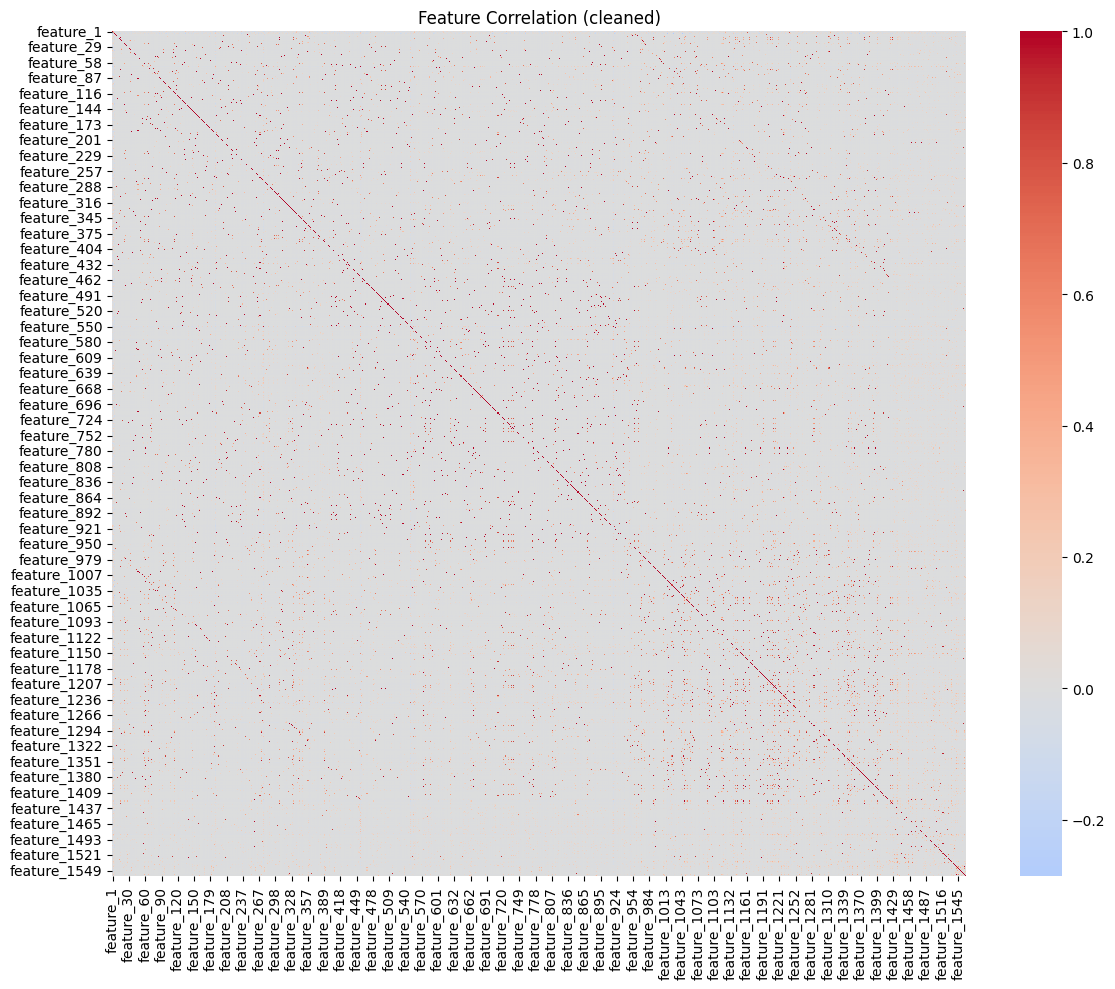

In [7]:
# 다시 히트맵
corr = train_df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (cleaned)")
plt.tight_layout()
plt.show()


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 1523 entries, feature_1 to Class
dtypes: float64(1), int64(1522)
memory usage: 20.5 MB


### 3-2. 상관계수 0.8 이상 컬럼 제거

Drop count: 1042
['feature_15', 'feature_16', 'feature_36', 'feature_39', 'feature_47', 'feature_69', 'feature_70', 'feature_72', 'feature_73', 'feature_75', 'feature_78', 'feature_79', 'feature_81', 'feature_83', 'feature_84', 'feature_85', 'feature_87', 'feature_88', 'feature_91', 'feature_93', 'feature_98', 'feature_100', 'feature_103', 'feature_108', 'feature_111', 'feature_112', 'feature_114', 'feature_115', 'feature_116', 'feature_118', 'feature_120', 'feature_122', 'feature_123', 'feature_125', 'feature_128', 'feature_130', 'feature_132', 'feature_134', 'feature_135', 'feature_136', 'feature_138', 'feature_139', 'feature_143', 'feature_144', 'feature_145', 'feature_151', 'feature_152', 'feature_154', 'feature_155', 'feature_158', 'feature_159', 'feature_161', 'feature_162', 'feature_163', 'feature_164', 'feature_165', 'feature_168', 'feature_169', 'feature_170', 'feature_171', 'feature_172', 'feature_177', 'feature_179', 'feature_180', 'feature_183', 'feature_185', 'feature_189'

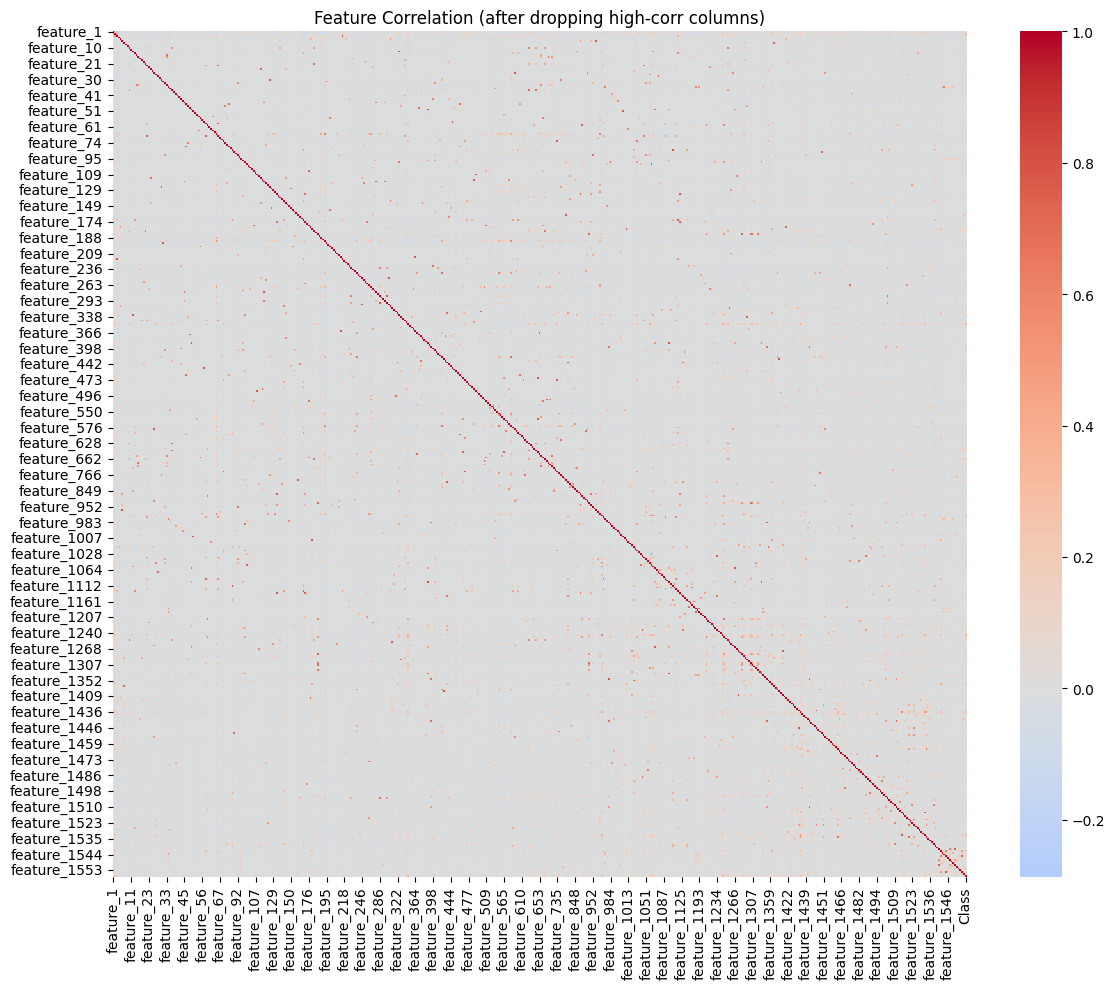

In [9]:
# 절댓값 상관계수 0.8 이상인 컬럼 제거
threshold = 0.8

# 숫자형만 상관계수
corr = train_df.select_dtypes(include=["number"]).corr().abs()

# 상삼각행렬만 사용 (중복 제거)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 임계치 초과 컬럼 선택
to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]

print("Drop count:", len(to_drop))

# 필요하면 목록 확인
print(to_drop)

train_df = train_df.drop(columns=to_drop)

train_df.info()
train_df.head()

# 제거 후 히트맵
corr_after = train_df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_after, cmap="coolwarm", center=0)
plt.title("Feature Correlation (after dropping high-corr columns)")
plt.tight_layout()
plt.show()

## 4. 탐색적 데이터 분석 (EDA)
> 분포, 차원 축소, 타겟 상관관계 시각화

In [10]:
# 1) 컬럼 타입 분리
num_cols = train_df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train_df.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

# 2) 숫자형: 분산 큰 Top 10 (분포/박스플롯 추천)
num_var = train_df[num_cols].var().sort_values(ascending=False)
print("\nTop variance numeric cols:")
print(num_var.head(10))

# 3) 숫자형: 왜도 큰 Top 10 (로그변환 전/후 비교 추천)
num_skew = train_df[num_cols].skew().sort_values(ascending=False)
print("\nTop skew numeric cols:")
print(num_skew.head(10))

# 4) 상관 높은 컬럼 쌍 Top 10 (산점도 추천)
corr = train_df[num_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .head(10)
)
print("\nTop correlated pairs:")
print(high_corr_pairs)

# 5) 범주형: 값 개수 많은 Top 10 (막대그래프/파이 추천)
if cat_cols:
    cat_card = train_df[cat_cols].nunique().sort_values(ascending=False)
    print("\nTop cardinality categorical cols:")
    print(cat_card.head(10))


Numeric cols: 481
Categorical cols: 0

Top variance numeric cols:
feature_2      16863.5263
feature_1       3118.3305
feature_3         20.8562
feature_188        0.2057
feature_4          0.1998
feature_193        0.1536
feature_1279       0.1197
feature_574        0.0751
Class              0.0746
feature_65         0.0674
dtype: float64

Top skew numeric cols:
feature_1013   41.9881
feature_369    41.9881
feature_150    41.9881
feature_1007   41.9881
feature_568    41.9881
feature_46     41.9881
feature_77     29.6648
feature_1529   29.6648
feature_463    29.6648
feature_153    29.6648
dtype: float64

Top correlated pairs:
feature_424   feature_1387   0.7994
feature_382   feature_1103   0.7992
feature_86    feature_1112   0.7968
feature_1103  feature_1336   0.7931
feature_133   feature_1124   0.7931
feature_173   feature_1123   0.7929
feature_51    feature_1004   0.7899
feature_214   feature_364    0.7899
feature_119   feature_282    0.7892
feature_286   feature_295    0.7892
dtype: 

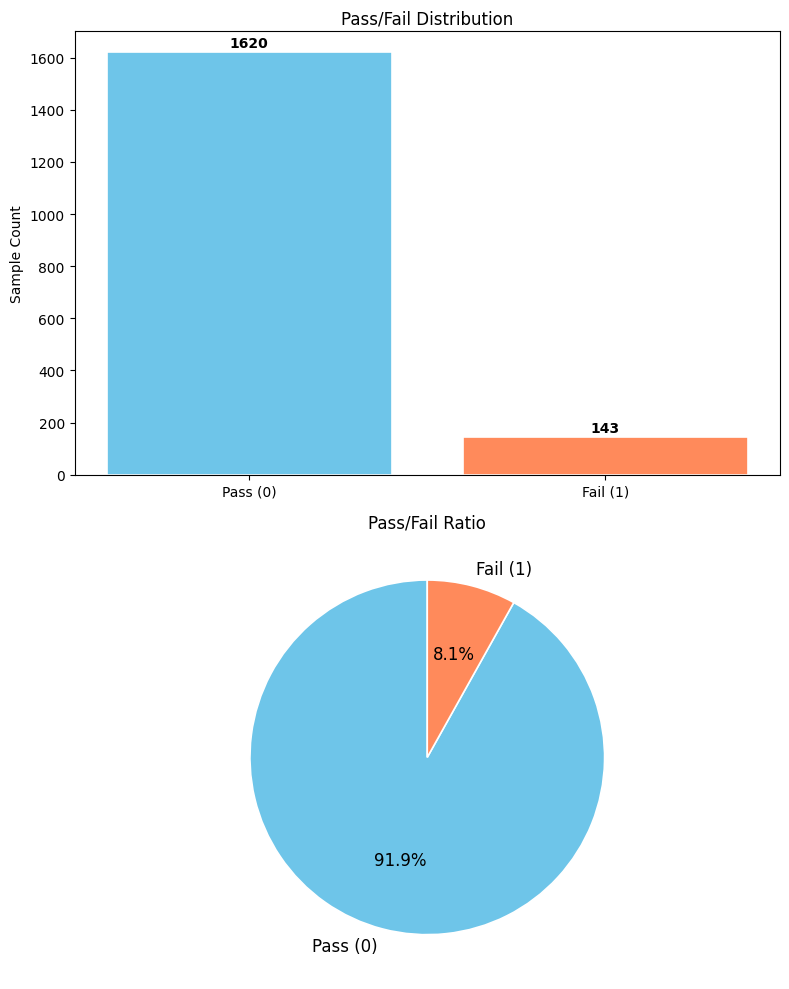

In [11]:
# =========================================
# 4. 타겟 분포 (Pass/Fail Ratio)
# =========================================
counts = train_df['Class'].value_counts().sort_index()
labels = ['Pass (0)', 'Fail (1)']
colors = ['#6EC5E9', '#FF8A5B']  # 파스텔 블루/코랄

fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Bar
axes[0].bar(labels, counts.values, color=colors, edgecolor='white', linewidth=1.2)
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 20, f'{v}', ha='center', fontweight='bold')
axes[0].set_ylabel('Sample Count')
axes[0].set_title('Pass/Fail Distribution')

# Pie
axes[1].pie(
    counts.values,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.2},
    textprops={'fontsize': 12}
)
axes[1].set_title('Pass/Fail Ratio')

plt.tight_layout()
plt.show()

In [12]:
# EDA용 데이터 준비 (결측치 대치 완료된 df 사용)
X = train_df.drop(columns=['Class'])
y = train_df['Class']

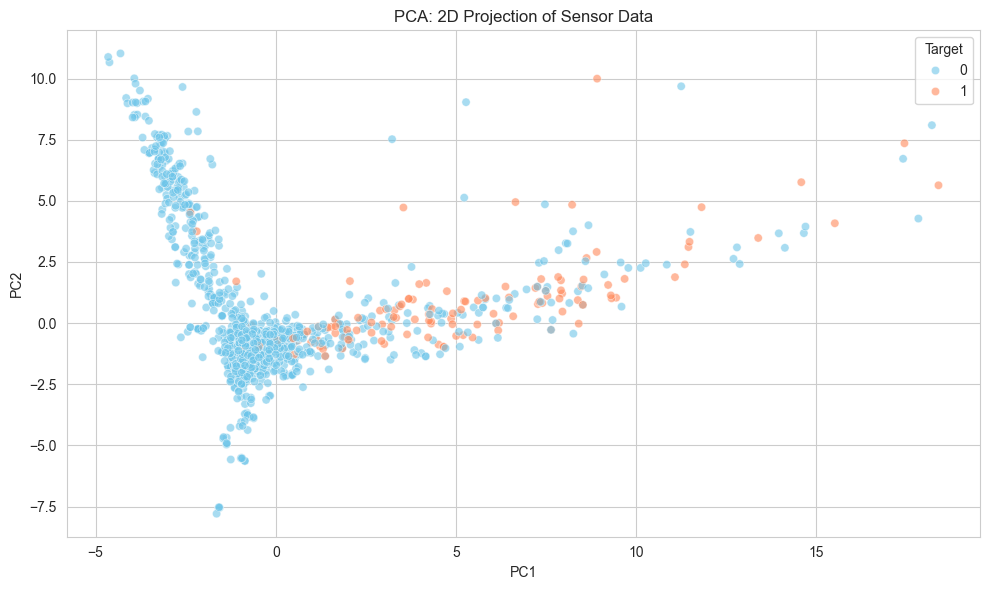

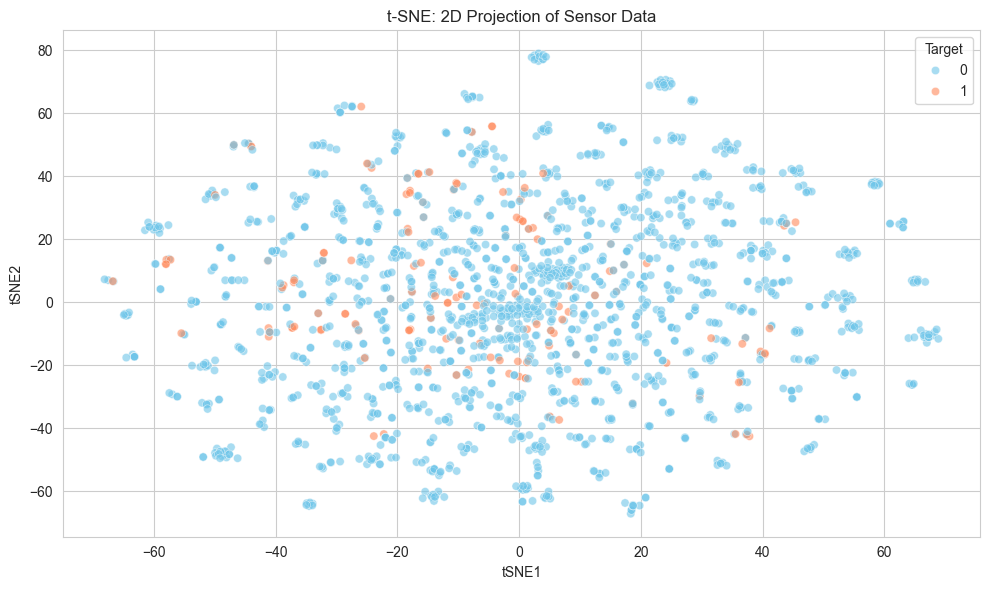

In [27]:
# PCA + t-SNE 시각화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = y.values

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
tsne_df['Target'] = y.values

palette = {0: '#6EC5E9', 1: '#FF8A5B'}

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Target',
                alpha=0.6, palette=palette)
plt.title('PCA: 2D Projection of Sensor Data')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Target',
                alpha=0.6, palette=palette)
plt.title('t-SNE: 2D Projection of Sensor Data')
plt.tight_layout()
plt.show()


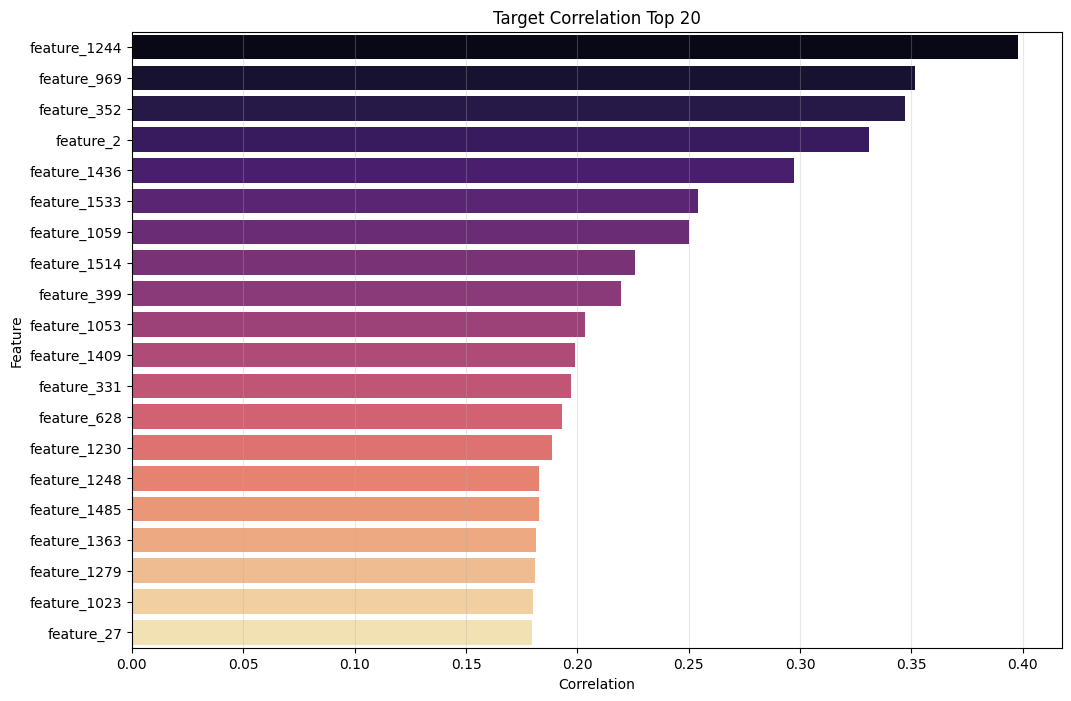

Target Correlation Top 20: feature_1244, feature_969, feature_352, feature_2, feature_1436, feature_1533, feature_1059, feature_1514, feature_399, feature_1053, feature_1409, feature_331, feature_628, feature_1230, feature_1248, feature_1485, feature_1363, feature_1279, feature_1023, feature_27
feature_1244   0.3977
feature_969    0.3516
feature_352    0.3470
feature_2      0.3307
feature_1436   0.2972
feature_1533   0.2542
feature_1059   0.2502
feature_1514   0.2258
feature_399    0.2196
feature_1053   0.2036
feature_1409   0.1989
feature_331    0.1972
feature_628    0.1930
feature_1230   0.1885
feature_1248   0.1829
feature_1485   0.1828
feature_1363   0.1816
feature_1279   0.1810
feature_1023   0.1803
feature_27     0.1795
dtype: float64


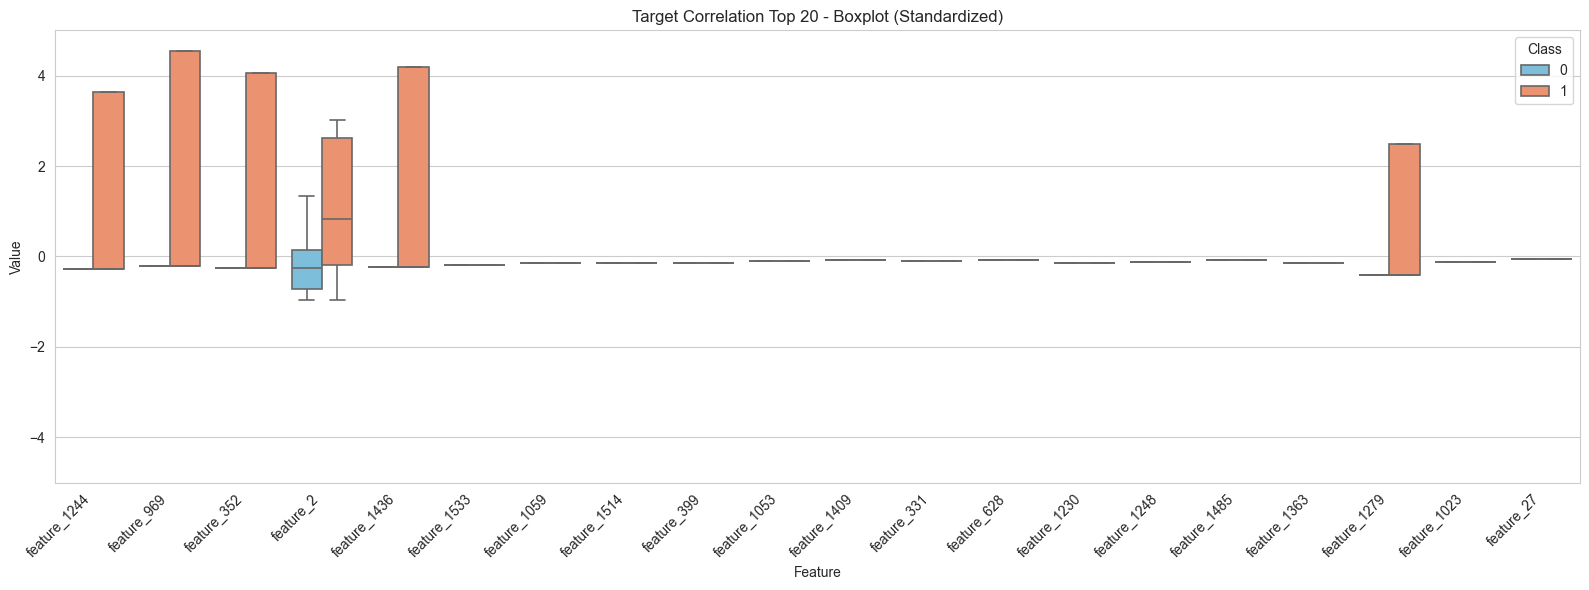

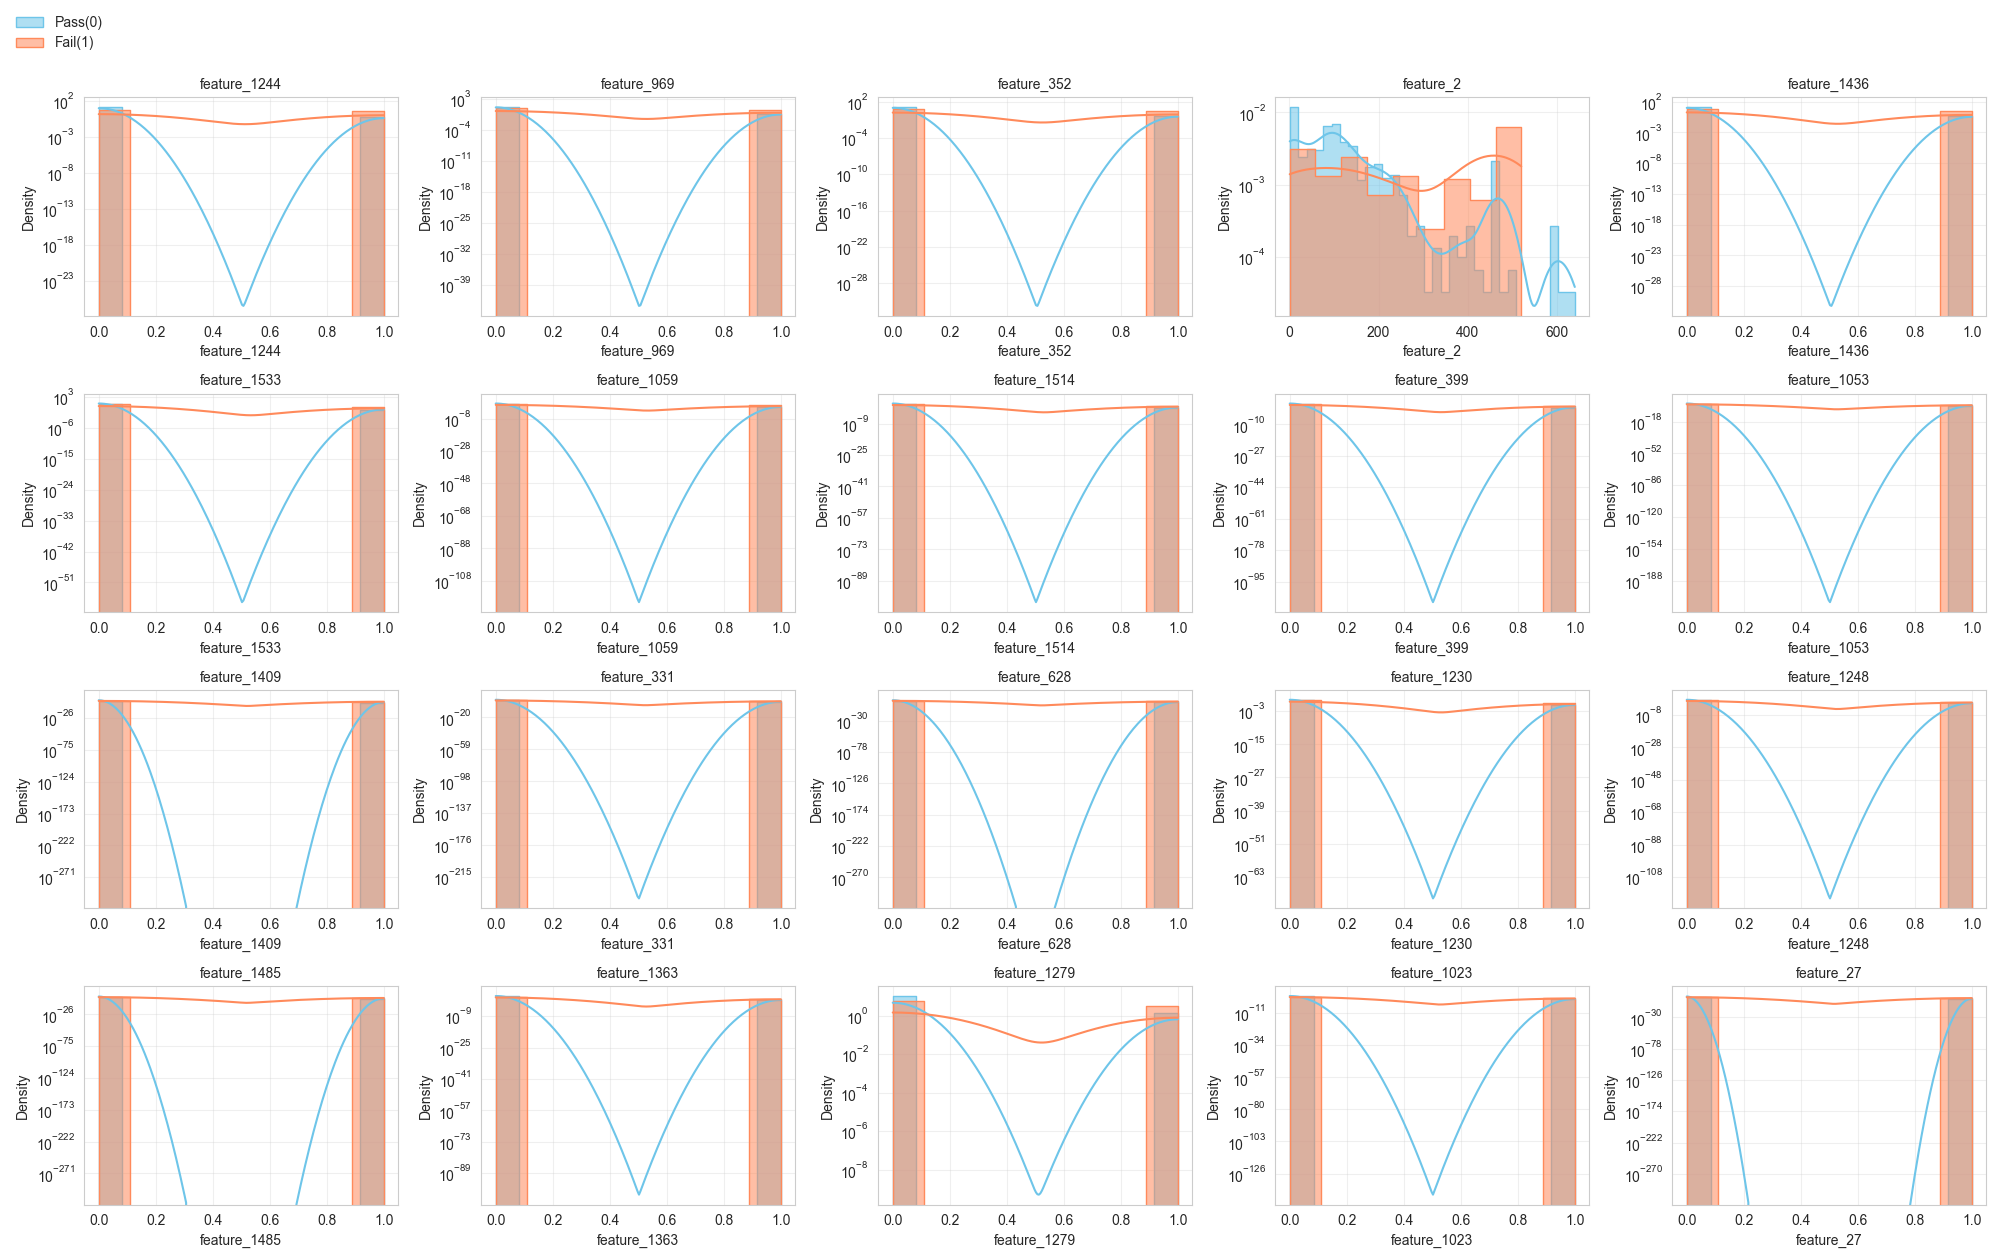

In [14]:
# Target Correlation Top 20

# =========================
# 1) 막대 그래프
# =========================
corr_with_target = X.corrwith(y).abs().sort_values(ascending=False)
top20_corr = corr_with_target.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top20_corr.values, y=top20_corr.index.astype(str), palette='magma')
plt.title('Target Correlation Top 20')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.show()

print(f"Target Correlation Top 20: {', '.join(top20_corr.index)}")
print(top20_corr)

# =========================
# 1) 박스플롯 (Top 20, 표준화)
# =========================
sns.set_style("whitegrid")

target = "Class"

top20 = top20_corr.index.tolist()
palette_pf = {0: "#6EC5E9", 1: "#FF8A5B", "0": "#6EC5E9", "1": "#FF8A5B"}

train_df_std = train_df.copy()
train_df_std[top20] = (train_df_std[top20] - train_df_std[top20].mean()) / train_df_std[top20].std()

train_df_melt = train_df_std.melt(id_vars=target, value_vars=top20, var_name="Feature", value_name="Value")

plt.figure(figsize=(16, 6))
sns.boxplot(
    data=train_df_melt,
    x="Feature",
    y="Value",
    hue=target,
    palette=palette_pf,
    linewidth=1.2,
    fliersize=0,
    whis=1.5
)
plt.ylim(-5, 5)
plt.xticks(rotation=45, ha='right')
plt.title("Target Correlation Top 20 - Boxplot (Standardized)")
plt.tight_layout()
plt.show()

# =========================
# 2) 히스토그램 (Top 20, 4x5)
# =========================
g0 = train_df[train_df[target].astype(str) == "0"]
g1 = train_df[train_df[target].astype(str) == "1"]

fig, axes = plt.subplots(4, 5, figsize=(20, 12))
for ax, col in zip(axes.flatten(), top20):
    sns.histplot(g0[col], color="#6EC5E9", label="Pass(0)", kde=True,
                 ax=ax, stat="density", alpha=0.55, element="step")
    sns.histplot(g1[col], color="#FF8A5B", label="Fail(1)", kde=True,
                 ax=ax, stat="density", alpha=0.55, element="step")
    ax.set_yscale('log')
    
    ax.set_title(str(col), fontsize=10)
    ax.grid(alpha=0.3)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left",
           bbox_to_anchor=(0.001, 1.05), frameon=False)
plt.tight_layout()
plt.show()

## 5. Train / Valid / Test 분리 + ANOVA 피처 선택
> 70 / 15 / 15 (stratified, seed=42) → ANOVA Top 20 피처 선택 (Train only)

In [15]:
# 1) Target 설정 (파일 확인 결과 'Class'임)
target = "Class" 

# Train.csv 데이터에서 X, y 분리
X = train_df.drop(columns=[target])
y = train_df[target].astype(int)

# 2) Train.csv 내부에서 분리 (Local Evaluation용)
# 먼저 Train(70%) vs Temp(30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
# Temp를 다시 Valid(15%) vs Local Test(15%)로 분리 (Temp 안에서 50:50)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 3) Train 데이터로만 피처 선택 학습 (Data Leakage 방지)
k = 20
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("anova", SelectKBest(score_func=f_classif, k=k))
])
pipe.fit(X_train, y_train)

# 선택된 컬럼명 추출
selected_cols = X_train.columns[pipe.named_steps["anova"].get_support()]

# 4) Train/Valid/Local Test에 선택된 컬럼 적용
X_train = X_train[selected_cols]
X_valid = X_valid[selected_cols]
X_test  = X_test[selected_cols]

# 5) 실제 테스트 파일(Test.csv)에도 동일한 피처 적용 (최종 제출용)
# test_df가 로드되어 있어야 합니다.
if 'test_df' in locals():
    # Test.csv에는 정답 컬럼이 없으므로 drop할 필요 없이 바로 선택
    X_submission = test_df[selected_cols]
    print(f"Submission (X_submission): {X_submission.shape}")
else:
    print("Warning: 'test_df' 변수가 없습니다. Test.csv를 로드해주세요.")

anova_str = ", ".join(selected_cols)
print(f"\nANOVA Top {k}: {anova_str}")
print("Train      :", X_train.shape)
print("Valid      :", X_valid.shape)
print("Test (Local):", X_test.shape)


Submission (X_submission): (756, 20)

ANOVA Top 20: feature_2, feature_27, feature_331, feature_352, feature_399, feature_969, feature_984, feature_1010, feature_1023, feature_1053, feature_1059, feature_1244, feature_1248, feature_1279, feature_1363, feature_1409, feature_1436, feature_1485, feature_1514, feature_1533
Train      : (1234, 20)
Valid      : (264, 20)
Test (Local): (265, 20)


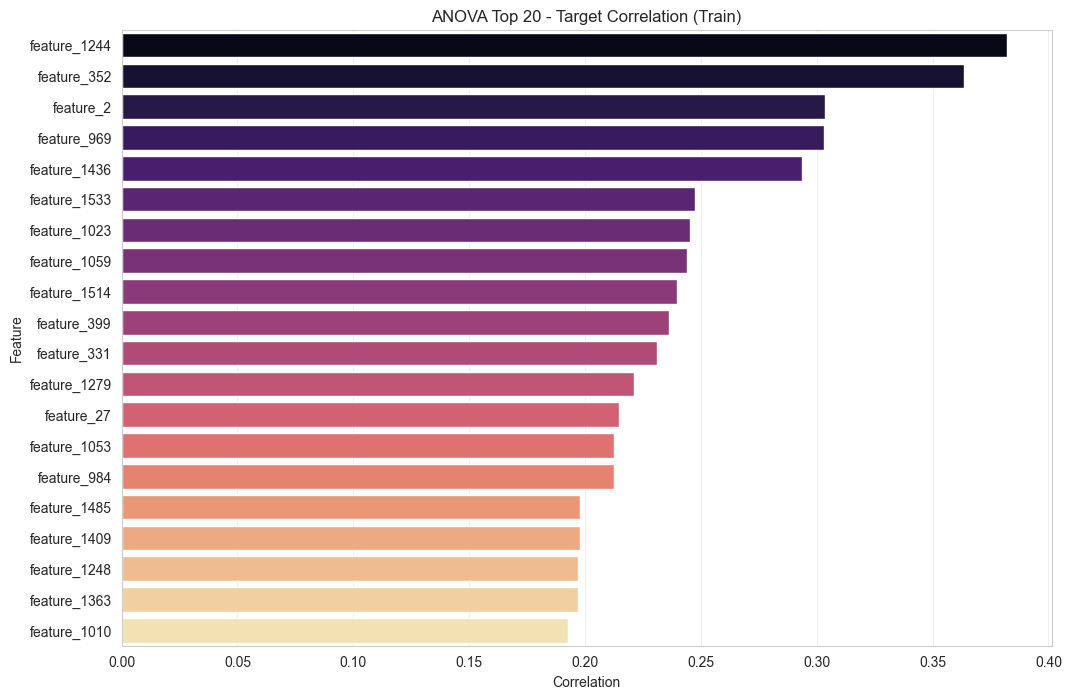

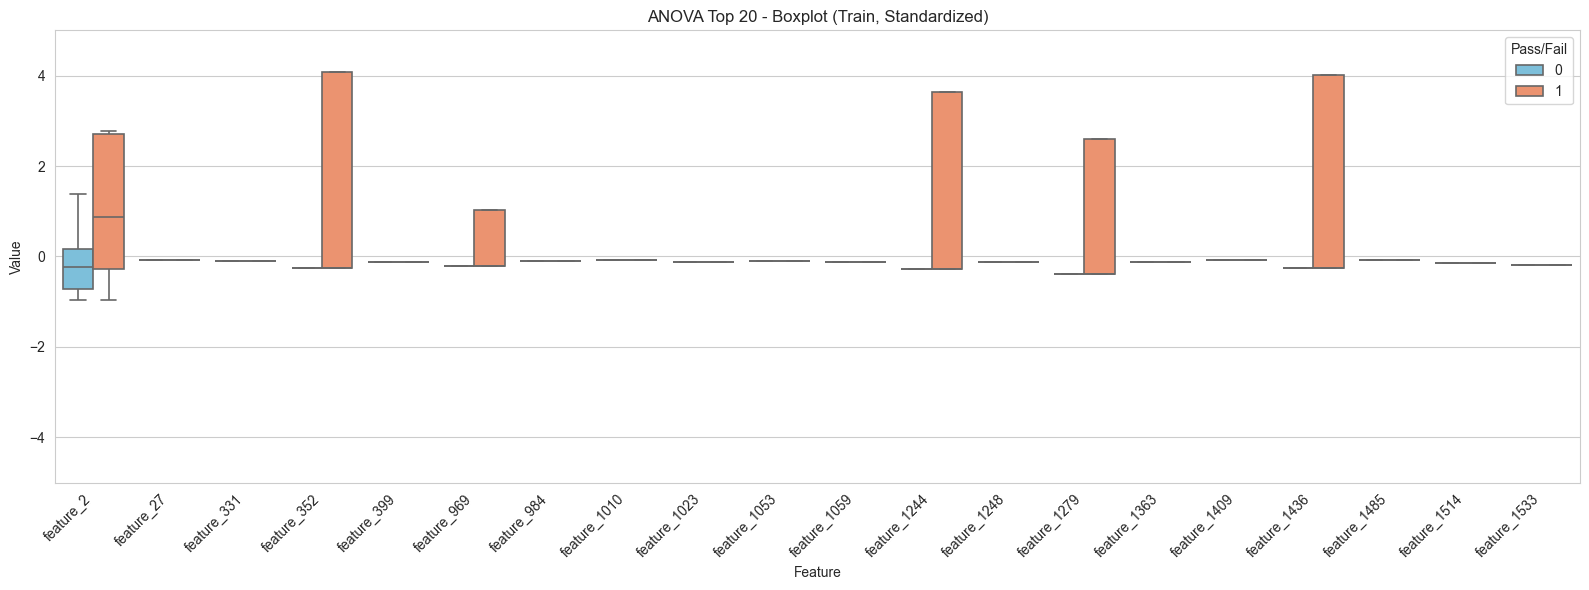

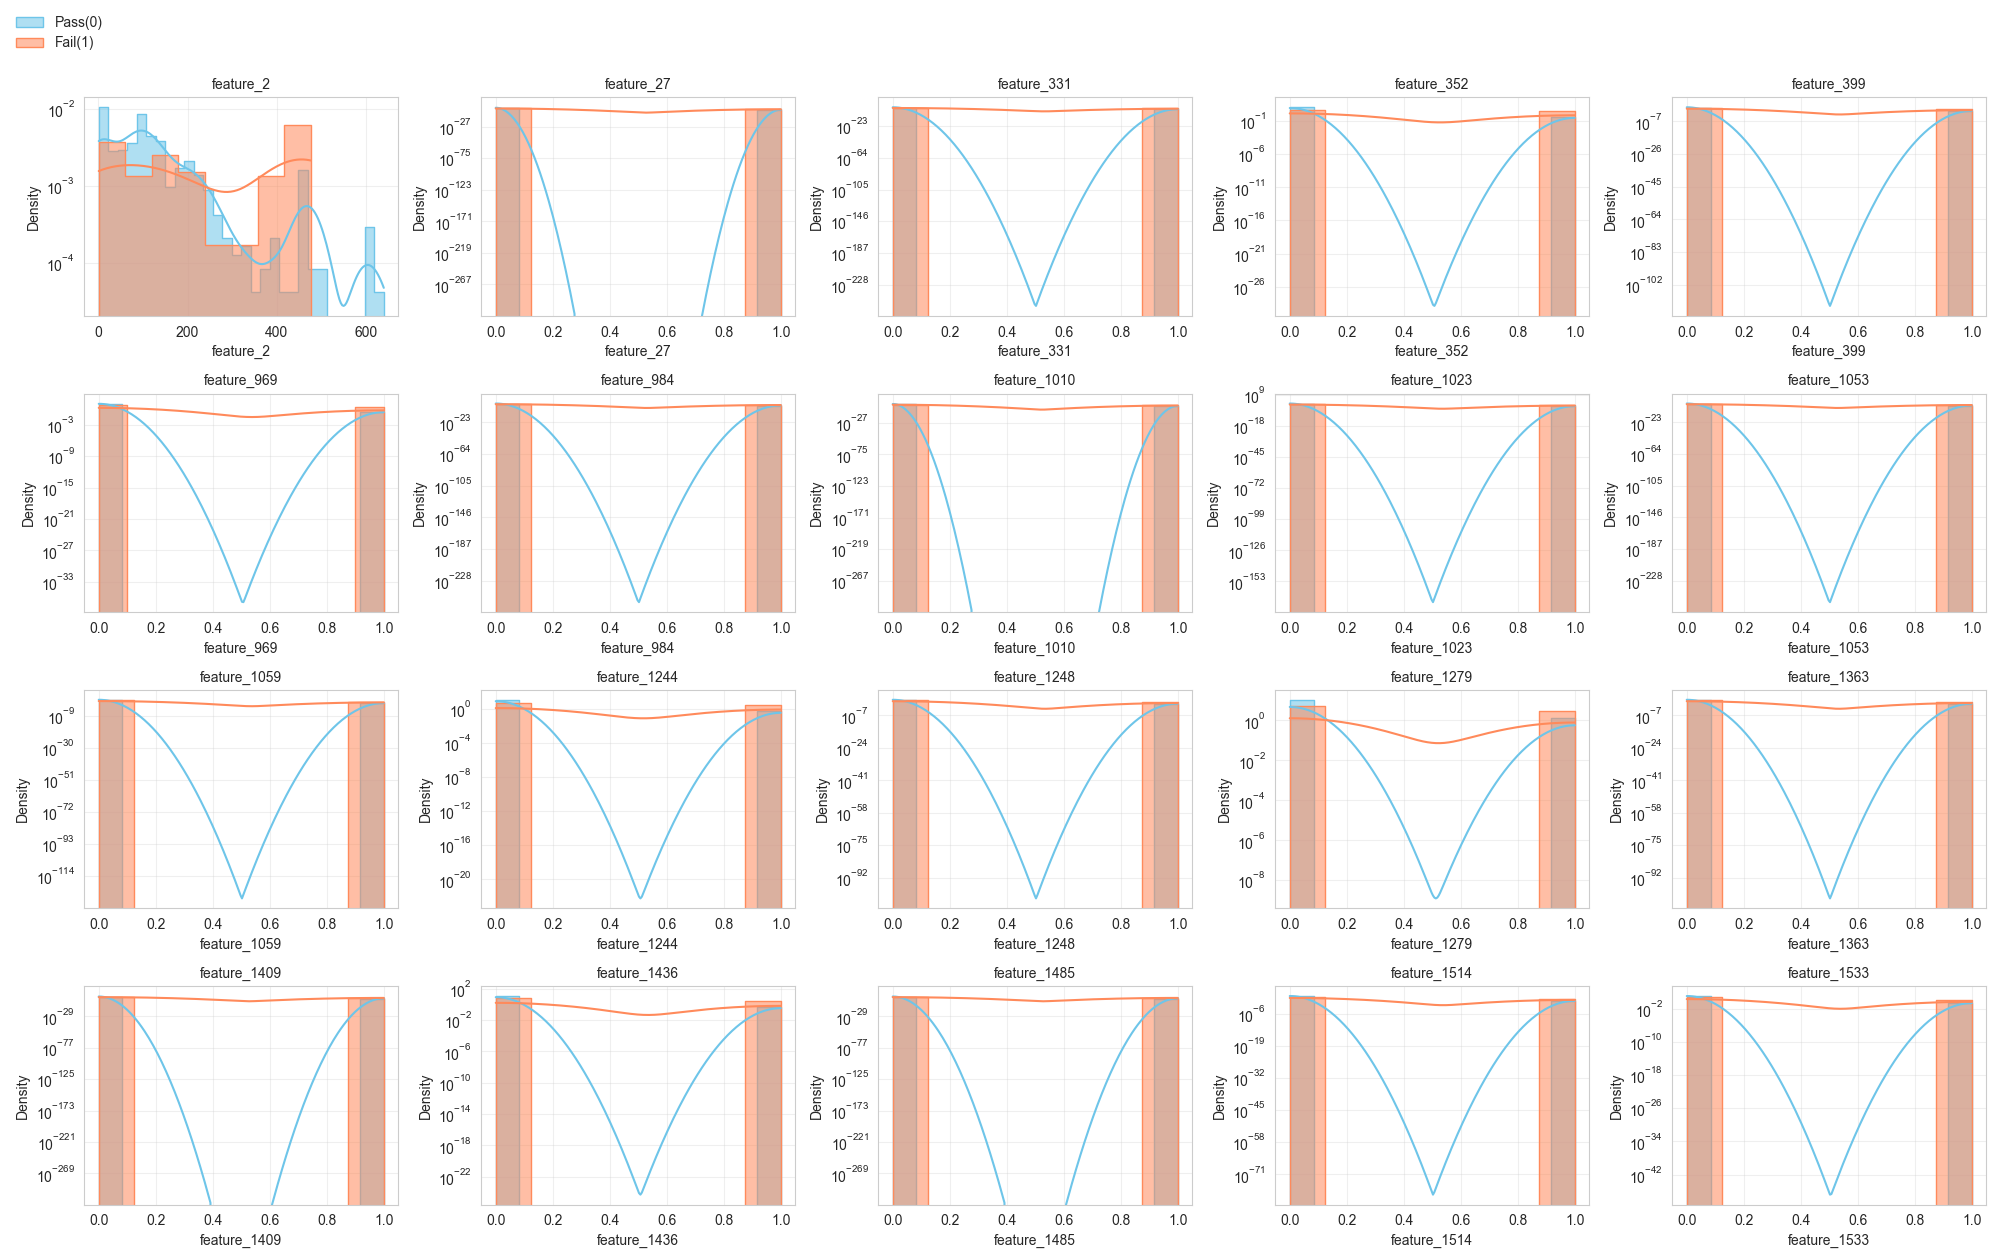

In [16]:
# =========================================
# 5. ANOVA Top 20 시각화 (Train only)
# =========================================
sns.set_style("whitegrid")

top20_anova = selected_cols.tolist()

# 1) Correlation bar chart (train data)
corr_train = X_train.corrwith(y_train).abs().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=corr_train.values, y=corr_train.index.astype(str), palette='magma')
plt.title('ANOVA Top 20 - Target Correlation (Train)')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.show()

# 2) Boxplot (train, standardized)
df_train = X_train.copy()
df_train['Pass/Fail'] = y_train.values

df_std = df_train.copy()
df_std[top20_anova] = (df_std[top20_anova] - df_std[top20_anova].mean()) / df_std[top20_anova].std()

df_melt = df_std.melt(id_vars='Pass/Fail', value_vars=top20_anova, var_name='Feature', value_name='Value')

plt.figure(figsize=(16, 6))
sns.boxplot(
    data=df_melt, x='Feature', y='Value', hue='Pass/Fail',
    palette={0: '#6EC5E9', 1: '#FF8A5B'},
    linewidth=1.2, fliersize=0, whis=1.5
)
plt.ylim(-5, 5)
plt.xticks(rotation=45, ha='right')
plt.title('ANOVA Top 20 - Boxplot (Train, Standardized)')
plt.tight_layout()
plt.show()

# 3) Histogram (4x5, train) - Log Scale (Y-axis)
g0 = df_train[df_train['Pass/Fail'] == 0]
g1 = df_train[df_train['Pass/Fail'] == 1]

fig, axes = plt.subplots(4, 5, figsize=(20, 12))

for ax, col in zip(axes.flatten(), top20_anova):
    sns.histplot(g0[col], color='#6EC5E9', label='Pass(0)', kde=True, 
                 ax=ax, stat='density', alpha=0.55, element="step")
    sns.histplot(g1[col], color='#FF8A5B', label='Fail(1)', kde=True, 
                 ax=ax, stat='density', alpha=0.55, element="step")
    
    ax.set_yscale('log')
    
    ax.set_title(str(col), fontsize=10)
    ax.grid(alpha=0.3)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', 
           bbox_to_anchor=(0.001, 1.05), frameon=False)
plt.tight_layout()
plt.show()

## 6. 3종 샘플링 × 5 모델 비교
Normal / Undersampling / SMOTE × 5개 모델 = **15개 조합**
- 퇴화 모델 제거: 반대쪽 지표 ≥ 0.3 하한 필터
- Top 3 선택 → Phase 3 앙상블 입력

In [17]:
# --- 모델 정의 ---
models_def = {
    "Logistic": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestClassifier(
            n_estimators=300, max_depth=12, random_state=42,
            n_jobs=-1, class_weight="balanced"
        ))
    ]),
    "HistGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingClassifier(
            max_depth=8, learning_rate=0.05, random_state=42
        ))
    ]),
    "XGBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBClassifier(
            n_estimators=300, max_depth=8, learning_rate=0.05,
            random_state=42, n_jobs=-1, eval_metric="logloss"
        ))
    ]),
    "LightGBM": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMClassifier(
            n_estimators=300, max_depth=8, learning_rate=0.05,
            random_state=42, n_jobs=-1, verbose=-1
        ))
    ]),
}

# --- 평가 함수 ---
def eval_model(name, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_va)[:, 1]
    pred = (proba >= 0.5).astype(int)
    cm = confusion_matrix(y_va, pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        "model": name,
        "ROC-AUC": roc_auc_score(y_va, proba),
        "PR-AUC": average_precision_score(y_va, proba),
        "Precision": precision_score(y_va, pred, zero_division=0),
        "Recall": recall_score(y_va, pred, zero_division=0),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "F1": f1_score(y_va, pred, zero_division=0),
    }, cm


### 6-1. 개별 모델 베이스라인 (Normal, threshold=0.5)

,model,ROC-AUC,PR-AUC,Precision,Recall,Specificity,F1,BalAcc
2,HistGB,0.8672,0.5420,0.5556,0.4762,0.9671,0.5128,0.7216
0,Logistic,0.8728,0.5158,0.4412,0.7143,0.9218,0.5455,0.8180
4,LightGBM,0.8660,0.4811,0.5789,0.5238,0.9671,0.5500,0.7454
3,XGBoost,0.8539,0.4236,0.6000,0.5714,0.9671,0.5854,0.7693
1,RandomForest,0.8496,0.3668,0.5200,0.6190,0.9506,0.5652,0.7848


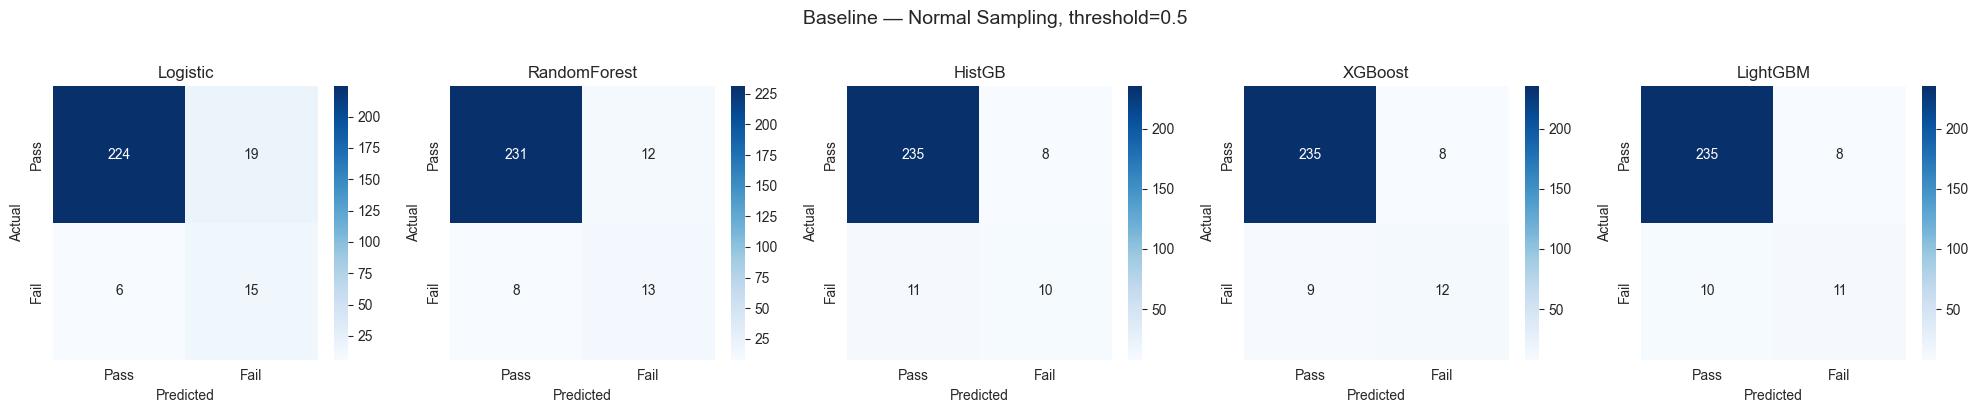

In [18]:
# Normal 샘플링 기준 5개 모델 베이스라인
baseline_results = []
baseline_cms = {}

for name, model_template in models_def.items():
    model = clone(model_template)
    result, cm = eval_model(name, model, X_train, y_train, X_valid, y_valid)
    result['Specificity'] = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    result['BalAcc'] = (result['Recall'] + result['Specificity']) / 2
    baseline_results.append(result)
    baseline_cms[name] = cm

display(pd.DataFrame(baseline_results).sort_values("PR-AUC", ascending=False))

# Confusion Matrix (threshold=0.5)
n = len(baseline_cms)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
for ax, (name, cm) in zip(axes, baseline_cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.suptitle("Baseline — Normal Sampling, threshold=0.5", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### 6-2. 3종 샘플링 × 5 모델 = 15개 조합 비교

,model,ROC-AUC,PR-AUC,Precision,Recall,Specificity,F1,BalAcc
0,Under_XGBoost,0.8634,0.5957,0.3333,0.8095,0.8601,0.4722,0.8348
1,Under_LightGBM,0.8652,0.5708,0.4444,0.7619,0.9177,0.5614,0.8398
2,Under_HistGB,0.8692,0.5533,0.3721,0.7619,0.8889,0.5000,0.8254
3,SMOTE_Logistic,0.8750,0.5480,0.4545,0.7143,0.9259,0.5556,0.8201
4,Normal_HistGB,0.8672,0.5420,0.5556,0.4762,0.9671,0.5128,0.7216
5,Under_Logistic,0.8705,0.5225,0.4444,0.7619,0.9177,0.5614,0.8398
6,Normal_Logistic,0.8728,0.5158,0.4412,0.7143,0.9218,0.5455,0.8180
7,Normal_LightGBM,0.8660,0.4811,0.5789,0.5238,0.9671,0.5500,0.7454
8,Under_RandomForest,0.8562,0.4347,0.3953,0.8095,0.8930,0.5312,0.8513
9,Normal_XGBoost,0.8539,0.4236,0.6000,0.5714,0.9671,0.5854,0.7693


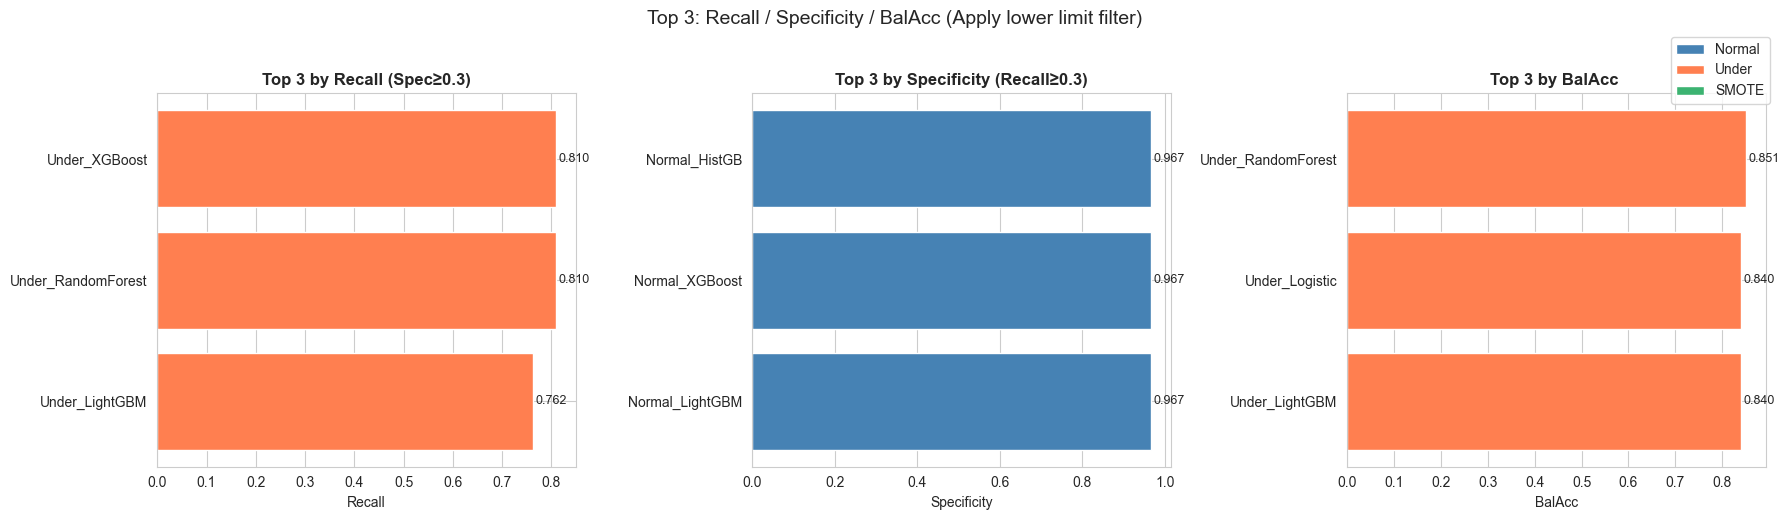

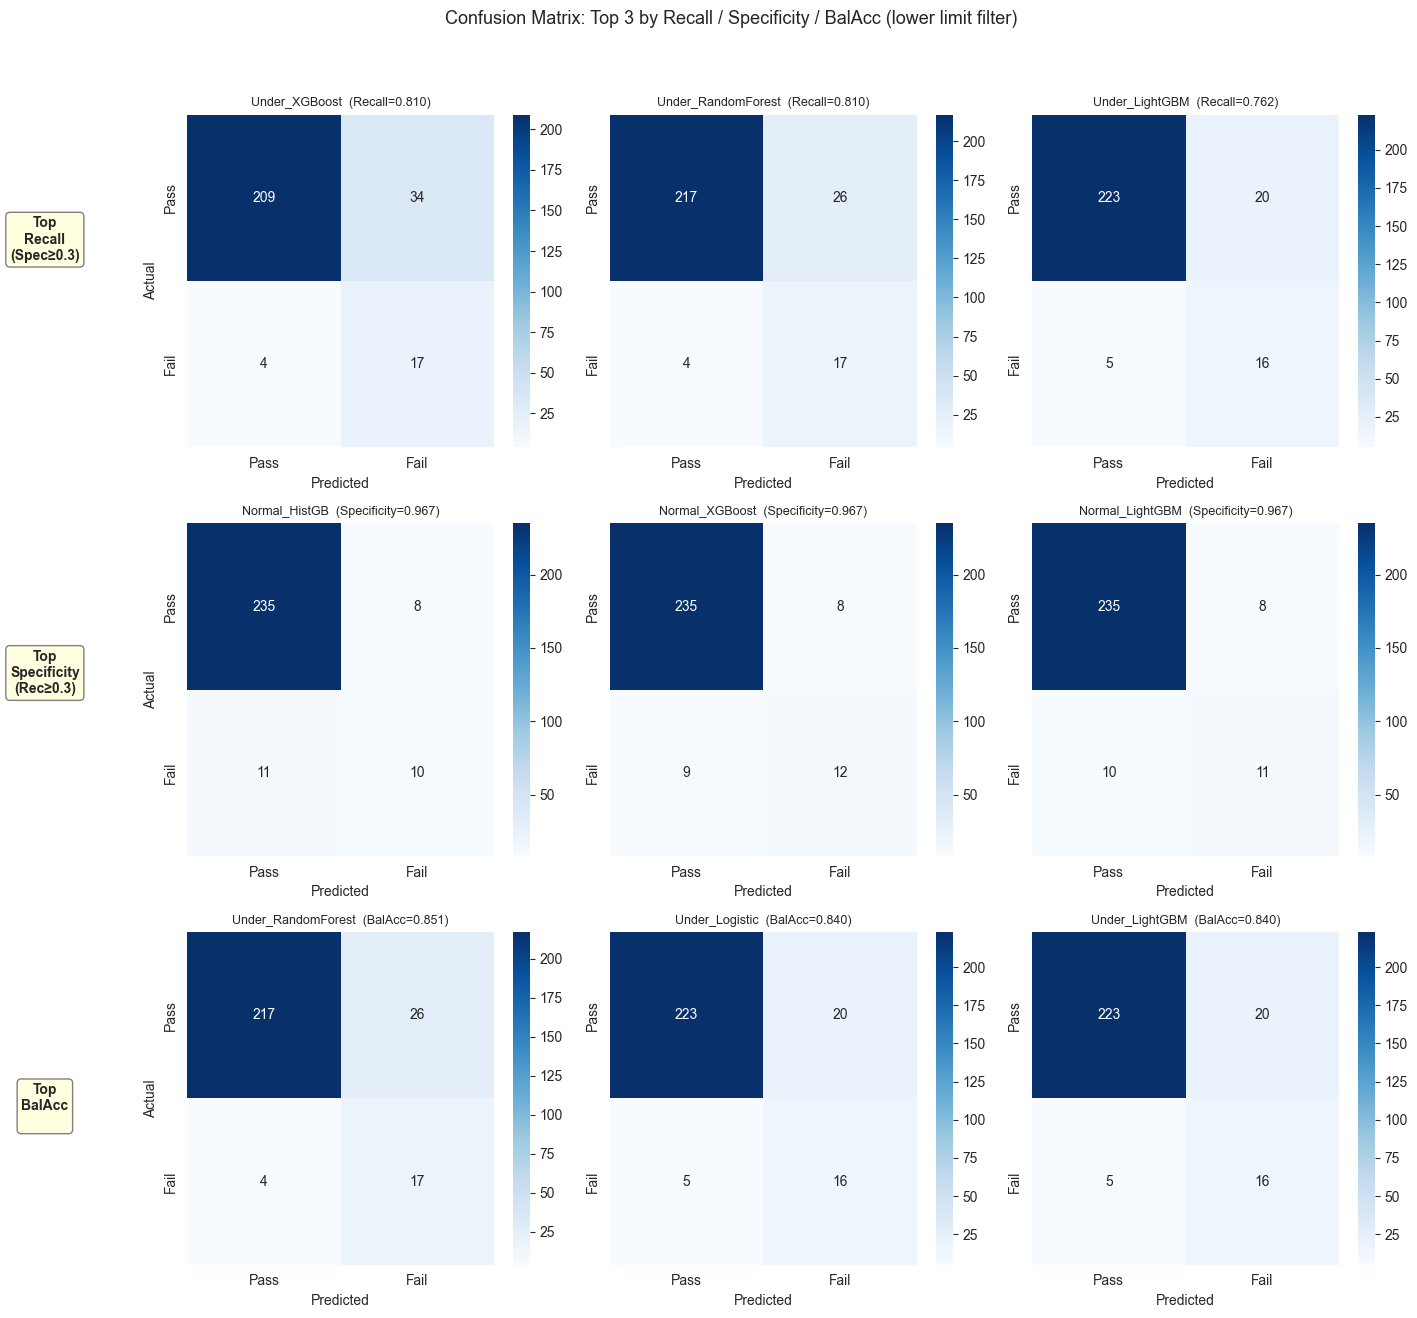

In [19]:
# === 3종 샘플링 × 5 모델 = 15개 조합 ===
sampling_methods = OrderedDict([
    ("Normal", None),
    ("Under",  RandomUnderSampler(random_state=42)),
    ("SMOTE",  SMOTE(random_state=42)),
])

all_results = []
trained_models = {}

for samp_name, sampler in sampling_methods.items():
    if sampler is not None:
        imp = SimpleImputer(strategy="median")
        X_tr_s = pd.DataFrame(
            imp.fit_transform(X_train),
            columns=X_train.columns
        )
        X_tr_s, y_tr_s = sampler.fit_resample(X_tr_s, y_train)
    else:
        X_tr_s, y_tr_s = X_train.copy(), y_train.copy()

    for model_name, model_template in models_def.items():
        model = clone(model_template)
        combo = f"{samp_name}_{model_name}"
        result, cm = eval_model(combo, model, X_tr_s, y_tr_s, X_valid, y_valid)
        all_results.append(result)
        trained_models[combo] = model

df_results = pd.DataFrame(all_results)
df_results["BalAcc"] = (df_results["Recall"] + df_results["Specificity"]) / 2
df_results = df_results.sort_values("PR-AUC", ascending=False).reset_index(drop=True)
display(df_results)

# --- 하한 필터 함수 (퇴화 모델 제거) ---
MIN_OPP = 0.3

def get_top3_filtered(df, metric):
    """Recall top → Spec≥0.3 풀, Spec top → Recall≥0.3 풀, BalAcc → 전체"""
    if metric == "Recall":
        pool = df[df["Specificity"] >= MIN_OPP]
    elif metric == "Specificity":
        pool = df[df["Recall"] >= MIN_OPP]
    else:
        pool = df
    return pool.sort_values(metric, ascending=False).head(3).reset_index(drop=True)

# --- Top 3 바차트 (Recall / Specificity / BalAcc) ---
metrics_top = ["Recall", "Specificity", "BalAcc"]
palette = {"Normal": "steelblue", "Under": "coral", "SMOTE": "mediumseagreen"}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, metrics_top):
    top3_m = get_top3_filtered(df_results, metric)
    colors = [palette[r.split("_")[0]] for r in top3_m["model"]]
    bars = ax.barh(range(3), top3_m[metric], color=colors)
    ax.set_yticks(range(3))
    ax.set_yticklabels(top3_m["model"], fontsize=10)
    ax.set_xlabel(metric)
    filt = "(Spec≥0.3)" if metric == "Recall" else "(Recall≥0.3)" if metric == "Specificity" else ""
    ax.set_title(f"Top 3 by {metric} {filt}", fontsize=12, fontweight="bold")
    ax.invert_yaxis()
    for i, v in enumerate(top3_m[metric]):
        ax.text(v + 0.005, i, f"{v:.3f}", va="center", fontsize=9)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for n, c in palette.items()]
fig.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(0.99, 0.99))
plt.suptitle("Top 3: Recall / Specificity / BalAcc (Apply lower limit filter)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

# --- Confusion Matrix 3x3 (각 지표 Top 3, 필터 적용) ---
fig, axes = plt.subplots(3, 3, figsize=(14, 13))
row_metrics = ["Recall", "Specificity", "BalAcc"]

for row_idx, metric in enumerate(row_metrics):
    top3_m = get_top3_filtered(df_results, metric)
    for col_idx in range(3):
        r = top3_m.iloc[col_idx]
        combo = r["model"]
        m = trained_models[combo]
        proba = m.predict_proba(X_valid)[:, 1]
        pred = (proba >= 0.5).astype(int)
        cm = confusion_matrix(y_valid, pred)
        ax = axes[row_idx][col_idx]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pass", "Fail"], yticklabels=["Pass", "Fail"], ax=ax)
        val = r[metric]
        ax.set_title(f"{combo}  ({metric}={val:.3f})", fontsize=9)
        ax.set_xlabel("Predicted")
        if col_idx == 0:
            ax.set_ylabel("Actual", fontsize=10)
        else:
            ax.set_ylabel("")

# 행 라벨 추가
for row_idx, label in enumerate(row_metrics):
    mid_y = 1 - (row_idx + 0.5) / 3
    filt = "(Spec≥0.3)" if label == "Recall" else "(Rec≥0.3)" if label == "Specificity" else ""
    fig.text(0.01, mid_y, f"Top\n{label}\n{filt}", fontsize=10, fontweight="bold",
             va="center", ha="center", rotation=0,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", edgecolor="gray"))

plt.suptitle("Confusion Matrix: Top 3 by Recall / Specificity / BalAcc (lower limit filter)", y=1.01, fontsize=13)
plt.tight_layout(rect=[0.07, 0, 1, 0.98])
plt.show()


## 7. Soft Voting 앙상블
Recall 1위(Spec≥0.3) + Specificity 1위(Recall≥0.3) + BalAcc 1위 → 가중치 × threshold 동시 탐색

  앙상블 모델 선택 (역할 분담, 하한 필터 ≥ 0.3)
  Recall 1위 (Spec≥0.3) : Under_XGBoost
    Recall=0.810  Spec=0.860  BalAcc=0.835
  Spec 1위  (Rec≥0.3) : Normal_HistGB
    Recall=0.476  Spec=0.967  BalAcc=0.722
  BalAcc (밸런스)     : Under_RandomForest
    Recall=0.810  Spec=0.893  BalAcc=0.851


,weights,threshold,Recall,Specificity,BalAcc
18,"[1,1,4]",0.6400,0.8095,0.9177,0.8636
24,"[1,1,5]",0.6500,0.8095,0.9177,0.8636
9,"[1,2,2]",0.4600,0.8095,0.9136,0.8616
3,"[1,1,2]",0.5500,0.8095,0.9136,0.8616
5,"[1,3,1]",0.3100,0.8095,0.9136,0.8616
6,"[1,1,3]",0.5700,0.8095,0.9136,0.8616
8,"[2,1,2]",0.5700,0.8095,0.9136,0.8616
11,"[3,1,2]",0.5700,0.8095,0.9136,0.8616
0,"균등 [1,1,1]",0.4800,0.8095,0.9136,0.8616
2,"[1,2,1]",0.3700,0.8095,0.9136,0.8616



  Best Weights : [1,1,4]
  Threshold    : 0.64
  BalAcc       : 0.8636


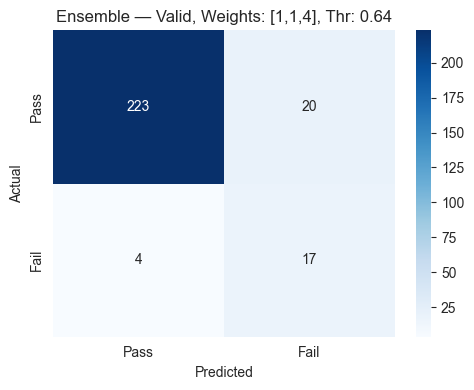

In [20]:
# === 앙상블 모델 조합: 역할 분담 + 하한 필터 ===
# Recall 1위: Spec >= 0.3 인 모델 중
# Spec 1위: Recall >= 0.3 인 모델 중
# BalAcc 1위: 필터 없음
MIN_OPP = 0.3

pick_recall = df_results[df_results['Specificity'] >= MIN_OPP].sort_values('Recall', ascending=False).iloc[0]['model']

pool_spec = df_results[df_results['Recall'] >= MIN_OPP]
if len(pool_spec) > 0:
    pick_spec = pool_spec.sort_values('Specificity', ascending=False).iloc[0]['model']
else:
    pick_spec = df_results.sort_values('BalAcc', ascending=False).iloc[0]['model']

pick_bal = df_results.sort_values('BalAcc', ascending=False).iloc[0]['model']

# 중복 제거
picks = list(dict.fromkeys([pick_recall, pick_spec, pick_bal]))
if len(picks) < 3:
    for _, row in df_results.sort_values('BalAcc', ascending=False).iterrows():
        if row['model'] not in picks:
            picks.append(row['model'])
        if len(picks) == 3:
            break

top3 = picks
print('=' * 60)
print('  앙상블 모델 선택 (역할 분담, 하한 필터 ≥ 0.3)')
print('=' * 60)
for i, n in enumerate(top3):
    row = df_results[df_results['model'] == n].iloc[0]
    if n == pick_recall:
        label = 'Recall 1위 (Spec≥0.3)'
    elif n == pick_spec:
        label = 'Spec 1위  (Rec≥0.3)'
    else:
        label = 'BalAcc (밸런스)    '
    print(f'  {label} : {n}')
    print(f'    Recall={row["Recall"]:.3f}  Spec={row["Specificity"]:.3f}  BalAcc={row["BalAcc"]:.3f}')
print('=' * 60)

def soft_vote(model_names, models_dict, X, weights=None):
    probas = [models_dict[n].predict_proba(X)[:, 1] for n in model_names]
    return np.average(probas, axis=0, weights=weights)

# --- 가중치 × threshold 동시 탐색 ---
weight_configs = OrderedDict([
    # --- 균등 ---
    ('균등 [1,1,1]', None),
    # --- 2:1 계열 ---
    ('[2,1,1]', [2, 1, 1]),
    ('[1,2,1]', [1, 2, 1]),
    ('[1,1,2]', [1, 1, 2]),
    # --- 3:1 계열 ---
    ('[3,1,1]', [3, 1, 1]),
    ('[1,3,1]', [1, 3, 1]),
    ('[1,1,3]', [1, 1, 3]),
    # --- 2:2:1 계열 ---
    ('[2,2,1]', [2, 2, 1]),
    ('[2,1,2]', [2, 1, 2]),
    ('[1,2,2]', [1, 2, 2]),
    # --- 3:2:1 계열 (6가지) ---
    ('[3,2,1]', [3, 2, 1]),
    ('[3,1,2]', [3, 1, 2]),
    ('[2,3,1]', [2, 3, 1]),
    ('[1,3,2]', [1, 3, 2]),
    ('[2,1,3]', [2, 1, 3]),
    ('[1,2,3]', [1, 2, 3]),
    # --- 4:1 계열 ---
    ('[4,1,1]', [4, 1, 1]),
    ('[1,4,1]', [1, 4, 1]),
    ('[1,1,4]', [1, 1, 4]),
    # --- 3:3:1 계열 ---
    ('[3,3,1]', [3, 3, 1]),
    ('[3,1,3]', [3, 1, 3]),
    ('[1,3,3]', [1, 3, 3]),
    # --- 5:1 계열 ---
    ('[5,1,1]', [5, 1, 1]),
    ('[1,5,1]', [1, 5, 1]),
    ('[1,1,5]', [1, 1, 5]),
    # --- 균등 고배 ---
    ('[2,2,2]', [2, 2, 2]),
])

thresholds = np.linspace(0.05, 0.95, 91)

ens_results = []
for w_name, w in weight_configs.items():
    proba_va = soft_vote(top3, trained_models, X_valid, w)

    best_bal, best_thr = 0, 0.5
    for thr in thresholds:
        pred = (proba_va >= thr).astype(int)
        cm = confusion_matrix(y_valid, pred)
        tn, fp, fn, tp = cm.ravel()
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        bal = (rec + spec) / 2
        if bal > best_bal:
            best_bal = bal
            best_thr = thr

    pred = (proba_va >= best_thr).astype(int)
    cm = confusion_matrix(y_valid, pred)
    tn, fp, fn, tp = cm.ravel()
    rec = recall_score(y_valid, pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ens_results.append({
        'weights': w_name,
        'threshold': best_thr,
        'PR-AUC': average_precision_score(y_valid, proba_va),
        'Recall': rec,
        'Specificity': spec,
        'BalAcc': (rec + spec) / 2,
        'Precision': precision_score(y_valid, pred, zero_division=0),
        'F1': f1_score(y_valid, pred, zero_division=0),
    })

df_ens = pd.DataFrame(ens_results)
display(df_ens[['weights', 'threshold', 'Recall', 'Specificity', 'BalAcc']].sort_values('BalAcc', ascending=False))

# --- Best 선택 ---
best_idx = df_ens['BalAcc'].idxmax()
best_w_name = df_ens.loc[best_idx, 'weights']
best_w = weight_configs[best_w_name]
best_thr = df_ens.loc[best_idx, 'threshold']
print()
print(f'  Best Weights : {best_w_name}')
print(f'  Threshold    : {best_thr:.2f}')
print(f'  BalAcc       : {df_ens.loc[best_idx, "BalAcc"]:.4f}')

# Confusion Matrix
proba_va = soft_vote(top3, trained_models, X_valid, best_w)
pred_va = (proba_va >= best_thr).astype(int)
cm_va = confusion_matrix(y_valid, pred_va)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_va, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=ax)
ax.set_title(f'Ensemble — Valid, Weights: {best_w_name}, Thr: {best_thr:.2f}')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()



  Test Set 최종 평가 (Soft Voting Ensemble)
  Models : ['Under_XGBoost', 'Normal_HistGB', 'Under_RandomForest']
  Config : weights=[1,1,4], threshold=0.64
  ───────────────────────────────────────────────
  PR-AUC=0.3960  Recall=0.8182  Spec=0.8765
  Prec  =0.3750  F1    =0.5143  BalAcc=0.8474


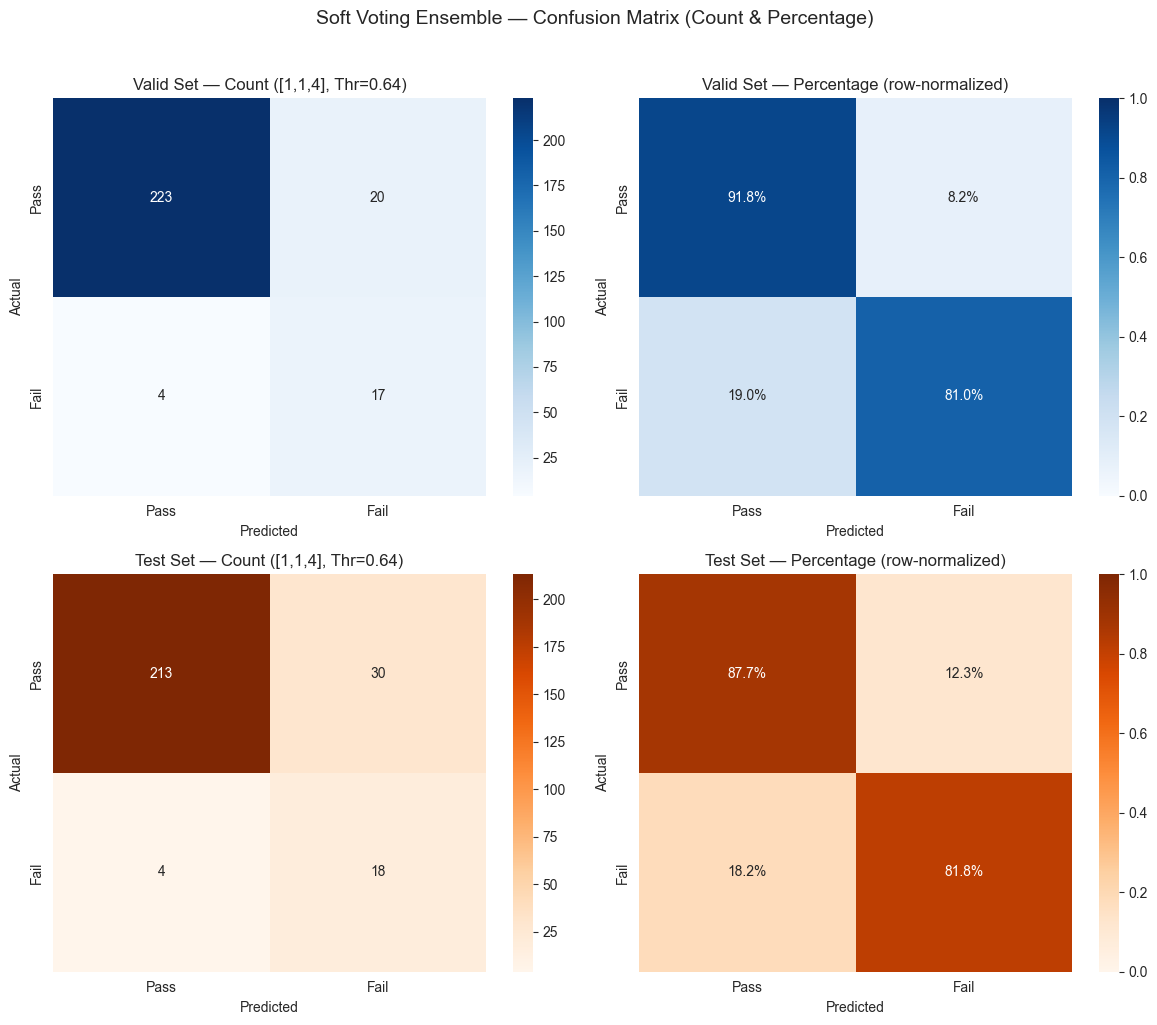

In [21]:
# === 최종 Test Set 평가 ===
proba_te = soft_vote(top3, trained_models, X_test, best_w)
pred_te = (proba_te >= best_thr).astype(int)

cm_test = confusion_matrix(y_test, pred_te)
tn, fp, fn, tp = cm_test.ravel()
rec_te = recall_score(y_test, pred_te, zero_division=0)
spec_te = tn / (tn + fp) if (tn + fp) > 0 else 0

print("=" * 55)
print("  Test Set 최종 평가 (Soft Voting Ensemble)")
print("=" * 55)
print(f"  Models : {top3}")
print(f"  Config : weights={best_w_name}, threshold={best_thr:.2f}")
print(f"  ───────────────────────────────────────────────")
pr_auc = average_precision_score(y_test, proba_te)
prec = precision_score(y_test, pred_te, zero_division=0)
f1 = f1_score(y_test, pred_te, zero_division=0)
bal = (rec_te + spec_te) / 2
print(f"  PR-AUC={pr_auc:.4f}  Recall={rec_te:.4f}  Spec={spec_te:.4f}")
print(f"  Prec  ={prec:.4f}  F1    ={f1:.4f}  BalAcc={bal:.4f}")
print("=" * 55)

# --- Confusion Matrix 2×2: Count + Percentage (Valid & Test) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Valid Count
sns.heatmap(cm_va, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[0,0])
axes[0,0].set_title(f'Valid Set — Count ({best_w_name}, Thr={best_thr:.2f})')
axes[0,0].set_xlabel('Predicted'); axes[0,0].set_ylabel('Actual')

# Valid Percentage (row-normalized)
cm_va_pct = cm_va.astype(float) / cm_va.sum(axis=1, keepdims=True)
annot_va = np.array([[f'{v:.1%}' for v in row] for row in cm_va_pct])
sns.heatmap(cm_va_pct, annot=annot_va, fmt='', cmap='Blues',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[0,1],
            vmin=0, vmax=1)
axes[0,1].set_title('Valid Set — Percentage (row-normalized)')
axes[0,1].set_xlabel('Predicted'); axes[0,1].set_ylabel('Actual')

# Test Count
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[1,0])
axes[1,0].set_title(f'Test Set — Count ({best_w_name}, Thr={best_thr:.2f})')
axes[1,0].set_xlabel('Predicted'); axes[1,0].set_ylabel('Actual')

# Test Percentage (row-normalized)
cm_te_pct = cm_test.astype(float) / cm_test.sum(axis=1, keepdims=True)
annot_te = np.array([[f'{v:.1%}' for v in row] for row in cm_te_pct])
sns.heatmap(cm_te_pct, annot=annot_te, fmt='', cmap='Oranges',
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'], ax=axes[1,1],
            vmin=0, vmax=1)
axes[1,1].set_title('Test Set — Percentage (row-normalized)')
axes[1,1].set_xlabel('Predicted'); axes[1,1].set_ylabel('Actual')

plt.suptitle('Soft Voting Ensemble — Confusion Matrix (Count & Percentage)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Multi-Seed Robustness Check
10개 시드(0, 10, 20, 30, 40, 50, 60, 70, 80, 90)로 전체 파이프라인 반복
- 단일 시드 과적합 여부 검증
- Valid-Test BalAcc gap 측정
- 모델 선택 빈도 집계

In [22]:
# === Multi-Seed Robustness Check (Method A: 반대쪽 하한 필터) ===
import warnings
warnings.filterwarnings('ignore')

seeds = [0, 7, 21, 42, 99, 123, 256, 314, 777, 2024]
MIN_OPP = 0.3  # 반대쪽 지표 하한
target_col = 'Class'
X_all = train_df.drop(columns=[target_col])
y_all = train_df[target_col].astype(int)

multi_seed_results = []

for seed in seeds:
    # 1. Split (70/15/15)
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
        X_all, y_all, test_size=0.30, random_state=seed, stratify=y_all)
    X_va, X_te, y_va, y_te = train_test_split(
        X_tmp, y_tmp, test_size=0.50, random_state=seed, stratify=y_tmp)

    # 2. ANOVA k=20 (Train only)
    anova_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('anova', SelectKBest(score_func=f_classif, k=20))
    ])
    anova_pipe.fit(X_tr, y_tr)
    sel = X_tr.columns[anova_pipe.named_steps['anova'].get_support()]
    X_tr, X_va, X_te = X_tr[sel], X_va[sel], X_te[sel]

    # 3. 15개 모델 학습
    sampling = OrderedDict([
        ('Normal', None),
        ('Under',  RandomUnderSampler(random_state=seed)),
        ('SMOTE',  SMOTE(random_state=seed)),
    ])

    res_15 = []
    mdls = {}
    for sn, sampler in sampling.items():
        if sampler is not None:
            imp = SimpleImputer(strategy='median')
            Xs = pd.DataFrame(imp.fit_transform(X_tr), columns=X_tr.columns)
            Xs, ys = sampler.fit_resample(Xs, y_tr)
        else:
            Xs, ys = X_tr.copy(), y_tr.copy()
        for mn, mt in models_def.items():
            m = clone(mt)
            combo = f'{sn}_{mn}'
            r, _ = eval_model(combo, m, Xs, ys, X_va, y_va)
            r['BalAcc'] = (r['Recall'] + r['Specificity']) / 2
            res_15.append(r)
            mdls[combo] = m

    df_r = pd.DataFrame(res_15)

    # 4. Top 3 선택 — Method A: 반대쪽 하한 필터
    # Recall 1위: Spec >= MIN_OPP 인 모델 중
    pool_rec = df_r[df_r['Specificity'] >= MIN_OPP]
    pr = pool_rec.sort_values('Recall', ascending=False).iloc[0]['model']
    # Spec 1위: Recall >= MIN_OPP 인 모델 중
    pool_spc = df_r[df_r['Recall'] >= MIN_OPP]
    if len(pool_spc) > 0:
        ps = pool_spc.sort_values('Specificity', ascending=False).iloc[0]['model']
    else:
        ps = df_r.sort_values('BalAcc', ascending=False).iloc[0]['model']
    # BalAcc 1위
    pb = df_r.sort_values('BalAcc', ascending=False).iloc[0]['model']

    picks = list(dict.fromkeys([pr, ps, pb]))
    if len(picks) < 3:
        for _, row in df_r.sort_values('BalAcc', ascending=False).iterrows():
            if row['model'] not in picks:
                picks.append(row['model'])
            if len(picks) == 3:
                break

    # 5. Soft Voting — 가중치 × threshold 탐색
    def sv(names, md, X, w=None):
        return np.average([md[n].predict_proba(X)[:, 1] for n in names], axis=0, weights=w)

    wc = OrderedDict([
        ('균등', None), ('[2,1,1]', [2,1,1]), ('[1,2,1]', [1,2,1]),
        ('[1,1,2]', [1,1,2]), ('[3,1,1]', [3,1,1]), ('[1,3,1]', [1,3,1]),
        ('[1,1,3]', [1,1,3]), ('[2,2,1]', [2,2,1]), ('[2,1,2]', [2,1,2]),
        ('[1,2,2]', [1,2,2]),
    ])
    thrs = np.linspace(0.05, 0.95, 91)
    best_ba, best_t, best_wn, best_wv = 0, 0.5, '균등', None

    for wn, wv in wc.items():
        pva = sv(picks, mdls, X_va, wv)
        for t in thrs:
            pred = (pva >= t).astype(int)
            cm = confusion_matrix(y_va, pred)
            tn, fp, fn, tp = cm.ravel()
            rc = tp/(tp+fn) if (tp+fn) > 0 else 0
            sp = tn/(tn+fp) if (tn+fp) > 0 else 0
            ba = (rc + sp) / 2
            if ba > best_ba:
                best_ba, best_t, best_wn, best_wv = ba, t, wn, wv

    # 6. Test 평가
    pte = sv(picks, mdls, X_te, best_wv)
    pred_te = (pte >= best_t).astype(int)
    cm_te = confusion_matrix(y_te, pred_te)
    tn, fp, fn, tp = cm_te.ravel()
    rec_te = recall_score(y_te, pred_te, zero_division=0)
    spc_te = tn/(tn+fp) if (tn+fp) > 0 else 0

    multi_seed_results.append({
        'seed': seed, 'models': picks, 'weights': best_wn,
        'threshold': best_t, 'Valid_BalAcc': best_ba,
        'Test_PR-AUC': average_precision_score(y_te, pte),
        'Test_Recall': rec_te, 'Test_Specificity': spc_te,
        'Test_BalAcc': (rec_te + spc_te) / 2,
        'Test_Precision': precision_score(y_te, pred_te, zero_division=0),
        'Test_F1': f1_score(y_te, pred_te, zero_division=0),
    })
    print(f'Seed {seed:>4d}: BalAcc(V)={best_ba:.3f} → BalAcc(T)={(rec_te+spc_te)/2:.3f}  '
          f'Rec={rec_te:.3f}  Spec={spc_te:.3f}  [{best_wn}] thr={best_t:.2f}  {picks}')

df_multi = pd.DataFrame(multi_seed_results)

print()
print('=' * 70)
print('  Multi-Seed Summary — Method A (반대쪽 하한 ≥ 0.3)')
print('=' * 70)
cols = ['Test_PR-AUC', 'Test_Recall', 'Test_Specificity', 'Test_BalAcc', 'Test_F1']
for col in cols:
    v = df_multi[col]
    print(f'  {col:20s}: {v.mean():.4f} ± {v.std():.4f}  '
          f'(min={v.min():.4f}, max={v.max():.4f})')
print('=' * 70)

gap = df_multi['Valid_BalAcc'] - df_multi['Test_BalAcc']
print(f'  Valid-Test BalAcc gap: {gap.mean():.4f} ± {gap.std():.4f}')

from collections import Counter
all_picks = [m for ms in df_multi['models'] for m in ms]
print(f'\n  모델 선택 빈도 (총 {len(all_picks)}회):')
for name, cnt in Counter(all_picks).most_common():
    print(f'    {name}: {cnt}회')


Seed    0: BalAcc(V)=0.805 → BalAcc(T)=0.802  Rec=0.636  Spec=0.967  [균등] thr=0.66  ['Under_RandomForest', 'Normal_LightGBM', 'Normal_Logistic']
Seed    7: BalAcc(V)=0.934 → BalAcc(T)=0.752  Rec=0.545  Spec=0.959  [[2,2,1]] thr=0.61  ['Under_RandomForest', 'Normal_LightGBM', 'Under_Logistic']
Seed   21: BalAcc(V)=0.908 → BalAcc(T)=0.752  Rec=0.591  Spec=0.914  [[2,1,1]] thr=0.51  ['Under_Logistic', 'SMOTE_HistGB', 'Normal_Logistic']
Seed   42: BalAcc(V)=0.866 → BalAcc(T)=0.860  Rec=0.818  Spec=0.901  [[2,1,1]] thr=0.57  ['Under_RandomForest', 'Normal_HistGB', 'Under_Logistic']
Seed   99: BalAcc(V)=0.851 → BalAcc(T)=0.909  Rec=0.909  Spec=0.909  [[1,1,2]] thr=0.44  ['Under_LightGBM', 'SMOTE_RandomForest', 'Under_HistGB']
Seed  123: BalAcc(V)=0.939 → BalAcc(T)=0.775  Rec=0.636  Spec=0.914  [[2,1,1]] thr=0.49  ['Under_RandomForest', 'Normal_HistGB', 'Under_LightGBM']
Seed  256: BalAcc(V)=0.872 → BalAcc(T)=0.905  Rec=0.864  Spec=0.947  [[2,1,2]] thr=0.55  ['Under_RandomForest', 'SMOTE_Hist